In [1]:
%reset

# import libraries
import sympy as sym
import numpy as np

from IPython.display import display #for pretty printing

import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# create symbolic variables

# system parameters
g = sym.symbols('g')
X0,Z0 = sym.symbols(['X0','Z0']) # fixed position of first link
m1,m2,m3,m4 = sym.symbols(['m1','m2','m3','m4']) # mass of links
l1,l2,l3,l4 = sym.symbols(['l1','l2','l3','l4']) # length of links
In1,In2,In3,In4 = sym.symbols(['In1','In2','In3','In4']) # moment of intertia of links

# generalized coordinates
x,z,th1,th2,th3,th4 = sym.symbols(['x','z','theta1','theta2','theta3','theta4']) #position
dx,dz,dth1,dth2,dth3,dth4 = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{1}','\dot{\\theta}_{2}','\dot{\\theta}_{3}','\dot{\\theta}_{4}']) #velocity
ddx,ddz,ddth1,ddth2,ddth3,ddth4 = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{1}','\ddot{\\theta}_{2}','\ddot{\\theta}_{3}','\ddot{\\theta}_{4}']) #acceleration

q = sym.Matrix([[x],[z],[th1],[th2],[th3],[th4]]) #group into matrices
dq = sym.Matrix([[dx],[dz],[dth1],[dth2],[dth3],[dth4]])
ddq = sym.Matrix([[ddx],[ddz],[ddth1],[ddth2],[ddth3],[ddth4]])

# forces
tau1,tau2,tau3,tau4 = sym.symbols(['\\tau_1','\\tau_2','\\tau_3','\\tau_4']) 

print('Done')

Done


In [3]:
# STEP 1: position vector (COM of each link) 
#using relative angles 

x1 = X0 + 0.5*l1*sym.sin(th1)
z1 = Z0 - 0.5*l1*sym.cos(th1)

x2 = X0 + l1*sym.sin(th1) + 0.5*l2*sym.sin(th1+th2)
z2 = Z0 - l1*sym.cos(th1) - 0.5*l2*sym.cos(th1+th2)

x3 = X0 + 0.5*l3*sym.sin(th3)
z3 = Z0 - 0.5*l3*sym.cos(th3)

x4 = X0 + l3*sym.sin(th3) + 0.5*l4*sym.sin(th3+th4)
z4 = Z0 - l3*sym.cos(th3) - 0.5*l4*sym.cos(th3+th4)

print('Done')

Done


In [4]:
# STEP 2: generate expressions for the system space velocities
p1 = sym.Matrix([x1,z1])
v1 = p1.jacobian(q)*dq
[dx1,dz1] = v1

p2 = sym.Matrix([x2,z2])
v2 = p2.jacobian(q)*dq
[dx2,dz2] = v2 

p3 = sym.Matrix([x3,z3])
v3 = p3.jacobian(q)*dq
[dx3,dz3] = v3 

p4 = sym.Matrix([x4,z4])
v4 = p4.jacobian(q)*dq
[dx4,dz4] = v3 

print('Done')

Done


In [5]:
# STEP 3: generate expressions for the kinetic and potential energy

#Stacy Shield's method
# T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
# V = sym.Matrix([m1*g*y1 + m2*g*y2])

#Callen Fisher's method, better for bigger problems.
M1 = sym.Matrix([[m1,m1]])
M2 = sym.Matrix([[m2,m2]])
M3 = sym.Matrix([[m3,m3]])
M4 = sym.Matrix([[m4,m4]])

I1=sym.Matrix([[In1]])
I2=sym.Matrix([[In2]])
I3=sym.Matrix([[In3]])
I4=sym.Matrix([[In4]])

W1=sym.Matrix([[dth1]])
W2=sym.Matrix([[dth1+dth2]])
W3=sym.Matrix([[dth3]])
W4=sym.Matrix([[dth3+dth4]])

# linear kinetic energy:
Tl = 0.5*M1*sym.matrix_multiply_elementwise(v1,v1) + 0.5*M2*sym.matrix_multiply_elementwise(v2,v2) + 0.5*M3*sym.matrix_multiply_elementwise(v3,v3) + 0.5*M4*sym.matrix_multiply_elementwise(v4,v4)
# angular kinetic energy:
Tw =  0.5*I1*sym.matrix_multiply_elementwise(W1,W1) + 0.5*I2*sym.matrix_multiply_elementwise(W2,W2) + 0.5*I3*sym.matrix_multiply_elementwise(W3,W3) + 0.5*I4*sym.matrix_multiply_elementwise(W4,W4)
#this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([Tl[0]])+sym.Matrix([Tw[0]])
# potential energy
V = m1*g*p1[1] + m2*g*p2[1] + m3*g*p3[1] + m4*g*p4[1]
print('Done')

Done


In [6]:
#Use the manipulator equation to calculate the EoM
#EOM=Mddq+Cdq+G-Q-J.'*GRF ---> Callen's method

M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

Q = sym.zeros(len(q),1)
# Q[0]=0                 #X
# Q[1]=0                 #Z
# Q[2]=tau1              #th1
# Q[3]=tau2              #th2
# Q[4]=tau3              #th3
# Q[5]=tau4              #th4
           
EOM=M*ddq+C*dq+G-Q

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()  #--> Helps to make simulation faster for bigger problems
    
print('Done')

Done


In [7]:
#Stacy Shield tut1
#initial conditions
th10 = np.pi/4
th20 = 0
th30 = -np.pi/4
th40 = 0
dth10 = 0
dth20 = 0
dth30 = 0
dth40 = 0

h = 0.01

#parameters
X0val = 0
Z0val = 1

l1val = 0.12
l2val = 0.24
l3val = 0.12
l4val = 0.24

m1val = 0.35
m2val = 0.15
m3val = 0.35
m4val = 0.15

In1val = 1/12*m1val*l1val**2
In2val = 1/12*m2val*l2val**2
In3val = 1/12*m3val*l3val**2
In4val = 1/12*m4val*l4val**2

parameter_values = [(X0,X0val),(Z0,Z0val),(g,9.81),(m1,m1val),(m2,m2val),(m3,m3val),(m4,m4val),(l1,l1val),(l2,l2val),(l3,l3val),(l4,l4val),(In1,In1val),(In2,In2val),(In3,In3val),(In4,In4val)]

th1ar = [np.pi/4]
th2ar = [0]
th3ar = [-np.pi/4]
th4ar = [0]
dth1ar = [0]
dth2ar = [0]
dth3ar = [0]
dth4ar = [0]

print('Done')

Done


100
[0.7853981633974483, 0.7774303121880916, 0.761599811855988, 0.7381235906441715, 0.7073426316075433, 0.6697354580302383, 0.6259259236278164, 0.5766778998029476, 0.5228721791033561, 0.4654671623284987, 0.4054519944399898, 0.34380432582467285, 0.2814623790300557, 0.21931443323153504, 0.1582024823882901, 0.09893356617107214, 0.04229221333885095, -0.010950892172459828, -0.06003696324316405, -0.1042254152221479, -0.14280944009045515, -0.17514240000641007, -0.20067831713329914, -0.21903249749323933, -0.2300707046927168, -0.2340324202253921, -0.23167480259857468, -0.22437763708945427, -0.21409463374619414, -0.2030597366892036, -0.1933291282194711, -0.1864073035646476, -0.18313087947531836, -0.183766596262817, -0.18818452004370653, -0.19601302373727533, -0.20674848536741805, -0.21982544807188822, -0.2346600668261162, -0.2506772680849565, -0.2673282754277608, -0.2841023278914458, -0.3005346996689815, -0.31621218870173196, -0.3307767589369212, -0.34392778233012383, -0.35542320569520897, -0.36

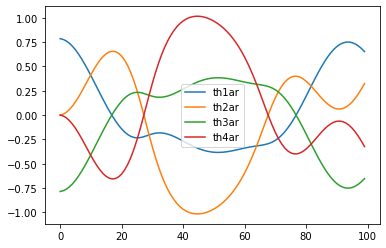

In [8]:
N = 100
for i in range(1,N):
    # substitute parameter values and previous conditions into the EOM 
    past = [(th1,th1ar[i-1]),(th2,th2ar[i-1]),(th3,th3ar[i-1]),(th4,th4ar[i-1]),(dth1,dth1ar[i-1]),(dth2,dth2ar[i-1]),(dth3,dth3ar[i-1]),(dth4,dth4ar[i-1])]
    EOM_sub = EOM.subs(parameter_values).subs(past)
    
    # solve for the acceleration
    acc = sym.solve(EOM_sub,[ddth1, ddth2, ddth3, ddth4])
#     display(parameter_values)
#     display(EOM_sub)
    
    # integrate for the next velocity and position    
    dth1ar.append(float(dth1ar[i-1]+h*acc[ddth1]))
    dth2ar.append(float(dth2ar[i-1]+h*acc[ddth2]))
    dth3ar.append(float(dth3ar[i-1]+h*acc[ddth3]))
    dth4ar.append(float(dth4ar[i-1]+h*acc[ddth4]))
    th1ar.append(float(th1ar[i-1]+h*dth1ar[i]))
    th2ar.append(float(th2ar[i-1]+h*dth2ar[i]))
    th3ar.append(float(th3ar[i-1]+h*dth3ar[i]))
    th4ar.append(float(th4ar[i-1]+h*dth4ar[i]))
size = len(th2ar)
print(size)
print(th1ar)    
plt.plot(range(len(dth1ar)),th1ar,label="th1ar")
plt.plot(range(len(dth2ar)),th2ar,label="th2ar")
plt.plot(range(len(dth3ar)),th3ar,label="th3ar")
plt.plot(range(len(dth4ar)),th4ar,label="th4ar")
plt.legend()
print('Done')

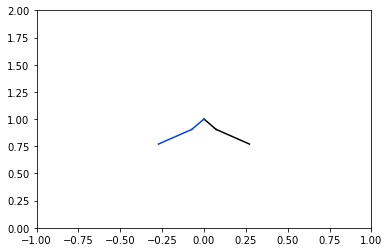

In [9]:
#animate it
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

fig1, ax1 = plt.subplots(1,1) #create axes

def plot_pendulum(i,th1_in,th2_in,th3_in,th4_in,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-1,1])
    ax.set_ylim([0,2])
    
    #plot link 1
    L1topx = X0val
    L1topy = Z0val
    L1bottomx = X0val + l1val*np.sin(th1_in[i])
    L1bottomy = Z0val - l1val*np.cos(th1_in[i])
    ax.plot([L1topx,L1bottomx],[L1topy,L1bottomy],color='xkcd:black')
    
    #plot link 2
    L2bottomx = L1bottomx + l2val*np.sin(th1_in[i] + th2_in[i])
    L2bottomy = L1bottomy - l2val*np.cos(th1_in[i] + th2_in[i]) 
    ax.plot([L1bottomx,L2bottomx],[L1bottomy,L2bottomy],color='xkcd:black')
    
    #plot link 3
    L3topx = X0val
    L3topy = Z0val
    L3bottomx = X0val + l3val*np.sin(th3_in[i])
    L3bottomy = Z0val - l3val*np.cos(th3_in[i])
    ax.plot([L3topx,L3bottomx],[L3topy,L3bottomy],color='xkcd:blue')
    
    #plot link 4
    L4bottomx = L3bottomx + l4val*np.sin(th3_in[i] + th4_in[i])
    L4bottomy = L3bottomy - l4val*np.cos(th3_in[i] + th4_in[i]) 
    ax.plot([L3bottomx,L4bottomx],[L3bottomy,L4bottomy],color='xkcd:blue')
    
update = lambda i: plot_pendulum(i,th1ar,th2ar,th3ar,th4ar,ax1) #lambdify update function

animation = ani.FuncAnimation(fig1,update,range(N),interval = 50,repeat=True)

HTML(animation.to_html5_video()) #you need to convert the animation to HTML5 to embed it in the notebook

